In [1]:
#lokale SA Fiala

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy 
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))

import Dugoff as du

sys.path.insert(0, os.path.abspath('../model/parameter'))
import Pacejka_Params_Indy as pa
import Params_fit_at_Pa52 as pam

i=1000
Sx = np.linspace(0,1,i)
Sy = np.linspace(0,0.3,i)
Fz0 = 3114
IA = 0
Fz = 4000
s=0.1

Cs_lat = 2.74289218e-01
Ca_lat = 6.16477615e+03
mu_lat = 1.43548745e-01
Fy_params = [Cs_lat, Ca_lat, mu_lat]

Cs_long = 1.54528498e+05
Ca_long = -1.96810483e+01
mu_long = 1.25090001e+00
Fx_params = [Cs_long, Ca_long, mu_long]

#Vergleichsfunktionen

def Fy_intervall(y,Fz,Fy_intv): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnene
    Fy_w=y
    w=len(Fy_w)
    Sy_max_pos=0
    for j in range(0,w):
        if Fy_w[j] == np.max(y):
            break
        else:
            Sy_max_pos = Sy_max_pos + 1

    #cut slop
    Fy_w_pos_max=Fy_w[0:((Sy_max_pos)+1)] #von 0 bis Fx_max
    Fy_w_max_end=Fy_w[((Sy_max_pos)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fy_max_ref = np.max(y) * Fy_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fy_w_pos_max)):
        if Fy_w_pos_max[j] < Fy_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fy_w_max_end)):
        if Fy_w_max_end[j] > Fy_max_ref:
            right +=1
        else:
            break
        
#Intervall 10% abweichung von Fx_max = [left,right]
    Fy_max_10=Fy_w[left:len(Fy_w_pos_max)+right]
    Fy_slope_b=((len(Fy_w_pos_max)+right)-left) / len(Fy_w) * 0.3#breite des Intervalls in %Schlupf
    
    l = left /len(y) * 0.3
    r = (len(Fy_w_pos_max) + right)/ len(y) * 0.3
    return Fy_slope_b,Fy_max_10,l,r

def Fx_intervall(y,Fz,Fx_intv): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnene
    Fx_w=y
    w=len(Fx_w)
    Sx_max_pos=0
    for j in range(0,w):
        if Fx_w[j] == np.max(y):
            break
        else:
            Sx_max_pos = Sx_max_pos + 1

    #cut slop
    Fx_w_pos_max=Fx_w[0:((Sx_max_pos)+1)] #von 0 bis Fx_max
    Fx_w_max_end=Fx_w[((Sx_max_pos)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fx_max_ref = np.max(y) * Fx_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fx_w_pos_max)):
        if Fx_w_pos_max[j] < Fx_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fx_w_max_end)):
        if Fx_w_max_end[j] > Fx_max_ref:
            right +=1
        else:
            break
        
#Intervall 10% abweichung von Fx_max = [left,right]
    Fx_max_10=Fx_w[left:len(Fx_w_pos_max)+right]
    Fx_slope_b=((len(Fx_w_pos_max)+right)-left) / len(Fx_w) #breite des Intervalls in %Schlupf
    
    l = left /len(y) 
    r = (len(Fx_w_pos_max) + right)/ len(y) 
    return Fx_slope_b,Fx_max_10,l,r


#ableiten
def diff_func(y,SL): #y = Funktion die abgleitet werden soll, Sl = linspace
    dx = SL[1]-SL[0]
    dydx = np.gradient(y, dx)
    return dydx


Text(0.5, 1.0, 'lokale SA Fy_max, Parameter +10% ')

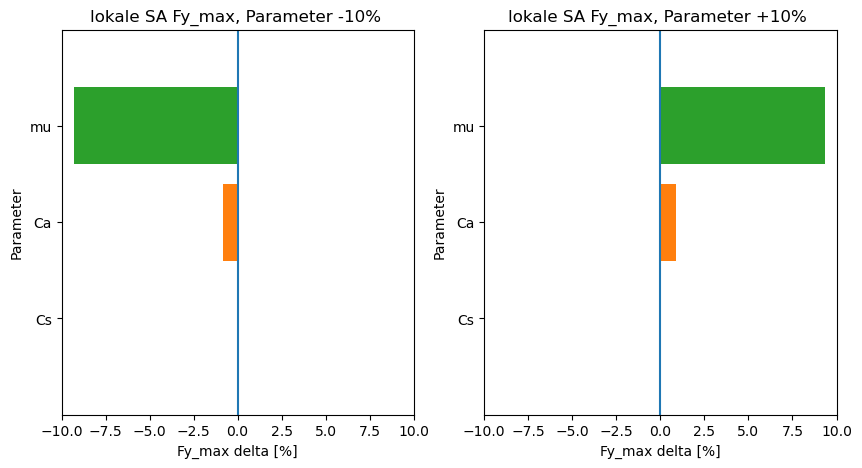

In [3]:
#Fy_max

delta=np.zeros((len(Fx_params),2))
Fy_params_pos = deepcopy(Fy_params)
Fy_params_neg = deepcopy(Fy_params)
i=0
for i in range(0,len(Fy_params)):

    Fy_params_pos[i] = Fy_params[i] * (1+s)
    delta_Fy_max_pos = ((np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))) - np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_pos)))/np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))
    Fy_params_pos[i] = Fy_params[i]  
    
    Fy_params_neg[i] = Fy_params_neg[i] * (1-s)
    delta_Fy_max_neg = ((np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))) - np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_neg)))/np.max(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))
    Fy_params_neg[i] = Fy_params[i]  

    delta[i] = [delta_Fy_max_neg*100, delta_Fy_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fy_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fy_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-10,10)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-10,10)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA Fy_max, Parameter +10% ')

Text(0.5, 1.0, 'Schräglaufwinkel bei Fy_max, Parameter +10% ')

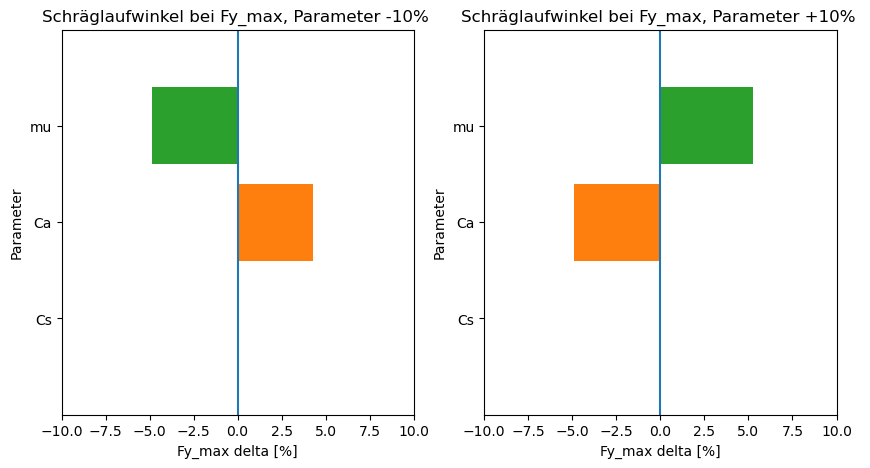

In [7]:
delta=np.zeros((len(Fx_params),2))
Fy_params_pos = deepcopy(Fy_params)
Fy_params_neg = deepcopy(Fy_params)
i=0
for i in range(0,len(Fy_params)):

    Fy_params_pos[i] = Fy_params[i] * (1+s)
    delta_Fy_max_pos = ((np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))) - np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_pos)))/np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))
    Fy_params_pos[i] = Fy_params[i]  
    
    Fy_params_neg[i] = Fy_params_neg[i] * (1-s)
    delta_Fy_max_neg = ((np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))) - np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_neg)))/np.argmax(du.dugoff_lat(Sx,Sy,Fz,*Fy_params))
    Fy_params_neg[i] = Fy_params[i]  

    delta[i] = [delta_Fy_max_neg*100, delta_Fy_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fy_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fy_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-10,10)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('Schräglaufwinkel bei Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-10,10)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('Schräglaufwinkel bei Fy_max, Parameter +10% ')

Text(0.5, 1.0, '90% Intervall bei Fy_max, Parameter +10% ')

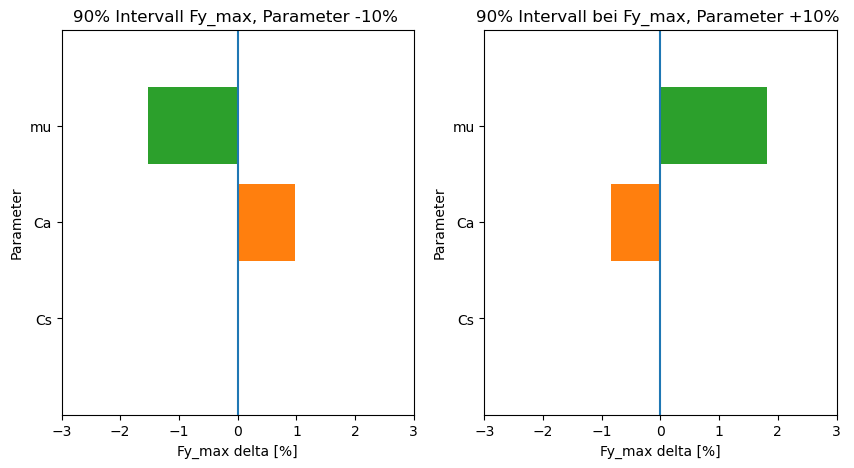

In [4]:
#90% Intervall

Fy_params_pos = deepcopy(Fy_params)
Fy_params_neg = deepcopy(Fy_params)
i=0
for i in range(0,len(Fy_params)):

    Fy_params_pos[i] = Fy_params[i] * (1+s)
    delta_Fy_max_pos = ((Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Fz,0.90)[0]) - Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_pos),Fz,0.90)[0])/Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Fz,0.90)[0]
    Fy_params_pos[i] = Fy_params[i]  
    
    Fy_params_neg[i] = Fy_params_neg[i] * (1-s)
    delta_Fy_max_neg = ((Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Fz,0.90)[0]) - Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_neg),Fz,0.90)[0])/Fy_intervall(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Fz,0.90)[0]
    Fy_params_neg[i] = Fy_params[i]  

    delta[i] = [delta_Fy_max_neg*100, delta_Fy_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fy_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fy_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-3,3)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('90% Intervall Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-3,3)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('90% Intervall bei Fy_max, Parameter +10% ')

Text(0.5, 1.0, 'Schräglaufsteifigkeit, Parameter +10% ')

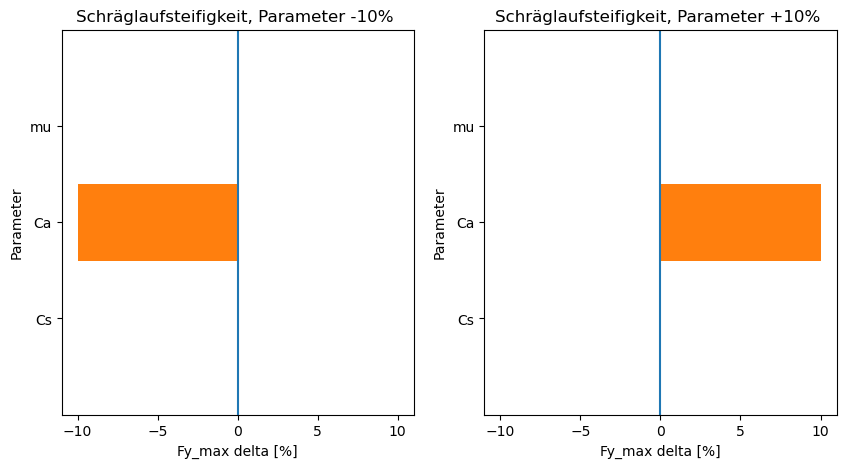

In [11]:
#Schräglaufsteifigkeit

Fy_params_pos = deepcopy(Fy_params)
Fy_params_neg = deepcopy(Fy_params)
i=0
for i in range(0,len(Fy_params)):

    Fy_params_pos[i] = Fy_params[i] * (1+s)
    delta_Fy_max_pos = (diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Sy)[0] - diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_pos),Sy)[0])/diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Sy)[0]
    Fy_params_pos[i] = Fy_params[i]  
    
    Fy_params_neg[i] = Fy_params_neg[i] * (1-s)
    delta_Fy_max_neg = (diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Sy)[0] - diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params_neg),Sy)[0])/diff_func(du.dugoff_lat(Sx,Sy,Fz,*Fy_params),Sy)[0]
    Fy_params_neg[i] = Fy_params[i]  

    delta[i] = [delta_Fy_max_neg*100, delta_Fy_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fy_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fy_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('Schräglaufsteifigkeit, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('Schräglaufsteifigkeit, Parameter +10% ')

Longitudinal

Text(0.5, 1.0, 'lokale SA Fy_max, Parameter +10% ')

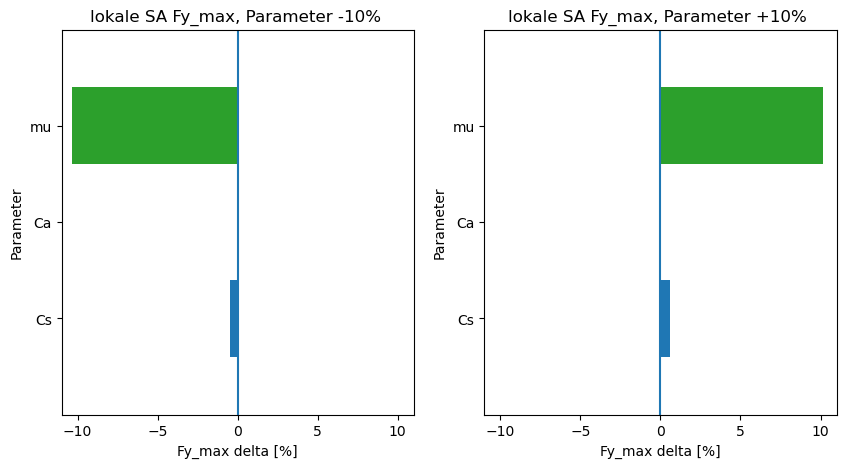

In [13]:
#Fx_max
delta=np.zeros((len(Fx_params),2))
Fx_params_pos = deepcopy(Fx_params)
Fx_params_neg = deepcopy(Fx_params)
i=0
for i in range(0,len(Fx_params)):

    Fx_params_pos[i] = Fx_params[i] * (1+s)
    delta_Fx_max_pos = ((np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params))) - np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params_pos)))/np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params))
    Fx_params_pos[i] = Fx_params[i]  
    
    Fx_params_neg[i] = Fx_params_neg[i] * (1-s)
    delta_Fx_max_neg = ((np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params))) - np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params_neg)))/np.max(du.dugoff_long(Sx,Sy,Fz, *Fx_params))
    Fx_params_neg[i] = Fx_params[i]  

    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fx_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fx_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA Fy_max, Parameter +10% ')

Text(0.5, 1.0, 'Schlupf bei Fy_max, Parameter +10% ')

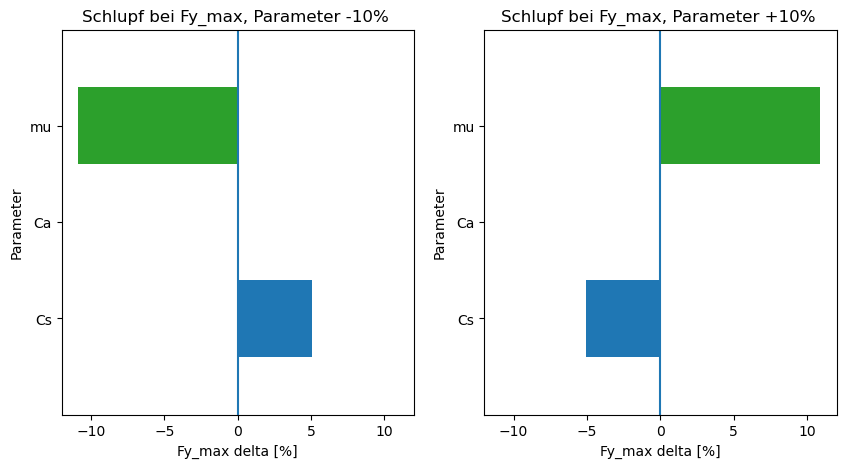

In [14]:
delta=np.zeros((len(Fx_params),2))
Fx_params_pos = deepcopy(Fx_params)
Fx_params_neg = deepcopy(Fx_params)
i=0
for i in range(0,len(Fx_params)):

    Fx_params_pos[i] = Fx_params[i] * (1+s)
    delta_Fx_max_pos = ((np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params))) - np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params_pos)))/np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params))
    Fx_params_pos[i] = Fx_params[i]  
    
    Fx_params_neg[i] = Fx_params_neg[i] * (1-s)
    delta_Fx_max_neg = ((np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params))) - np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params_neg)))/np.argmax(du.dugoff_long(Sx,Sy,Fz, *Fx_params))
    Fx_params_neg[i] = Fx_params[i]  

    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fx_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fx_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-12,12)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('Schlupf bei Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-12,12)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('Schlupf bei Fy_max, Parameter +10% ')

Text(0.5, 1.0, '90% Intervall Fy_max, Parameter +10% ')

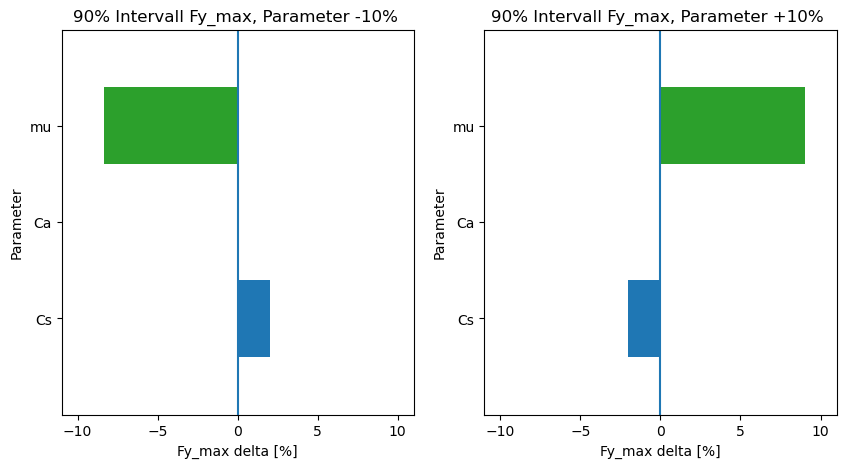

In [5]:
#90% intervall

delta=np.zeros((len(Fx_params),2))
Fx_params_pos = deepcopy(Fx_params)
Fx_params_neg = deepcopy(Fx_params)
i=0
for i in range(0,len(Fx_params)):

    Fx_params_pos[i] = Fx_params[i] * (1+s)
    delta_Fx_max_pos = (Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Fz,0.90)[0] - Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params_pos),Fz,0.90)[0])/Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Fz,0.90)[0]
    Fx_params_pos[i] = Fx_params[i]  
    
    Fx_params_neg[i] = Fx_params_neg[i] * (1-s)
    delta_Fx_max_neg = (Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Fz,0.90)[0] - Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params_neg),Fz,0.90)[0])/Fx_intervall(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Fz,0.90)[0]
    Fx_params_neg[i] = Fx_params[i]  

    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fx_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fx_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('90% Intervall Fy_max, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('90% Intervall Fy_max, Parameter +10% ')

Text(0.5, 1.0, 'Anfangssteigung, Parameter +10% ')

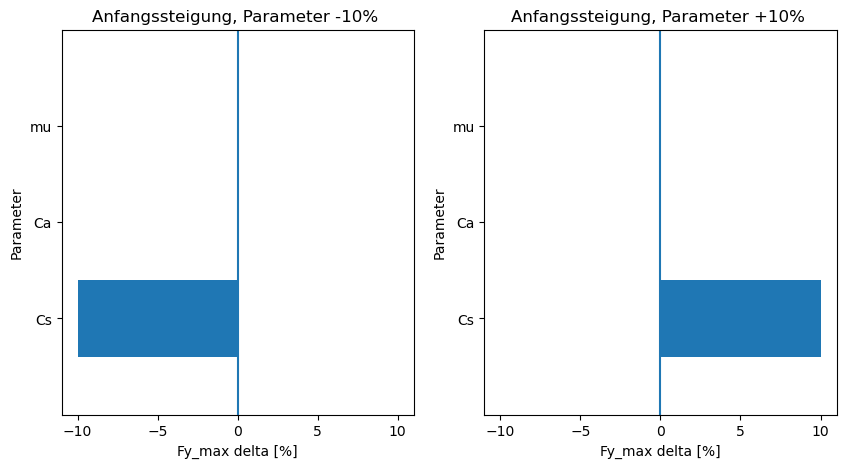

In [18]:
#Anfangssteigung

delta=np.zeros((len(Fx_params),2))
Fx_params_pos = deepcopy(Fx_params)
Fx_params_neg = deepcopy(Fx_params)
i=0
for i in range(0,len(Fx_params)):

    Fx_params_pos[i] = Fx_params[i] * (1+s)
    delta_Fx_max_pos = (diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Sx)[0] - diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params_pos),Sx)[0])/diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Sx)[0]
    Fx_params_pos[i] = Fx_params[i]  
    
    Fx_params_neg[i] = Fx_params_neg[i] * (1-s)
    delta_Fx_max_neg = (diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Sx)[0] - diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params_neg),Sx)[0])/diff_func(du.dugoff_long(Sx,Sy,Fz, *Fx_params),Sx)[0]
    Fx_params_neg[i] = Fx_params[i]  

    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]

delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(Fx_params)):
    delta_pos[i,0] = 0

for i in range(0,len(Fx_params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_pos)):
    ax1.barh(y_pos[i],delta_pos[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('Anfangssteigung, Parameter -10% ')

y_axis=('Cs', 'Ca', 'mu')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(delta_neg)):
    ax2.barh(y_pos[i],delta_neg[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('Anfangssteigung, Parameter +10% ')